In [1]:
from dygdug import vortexprop as vp
from prysm.coordinates import make_xy_grid
from prysm.propagation import Wavefront
from prysm.mathops import np

import matplotlib.pyplot as plt

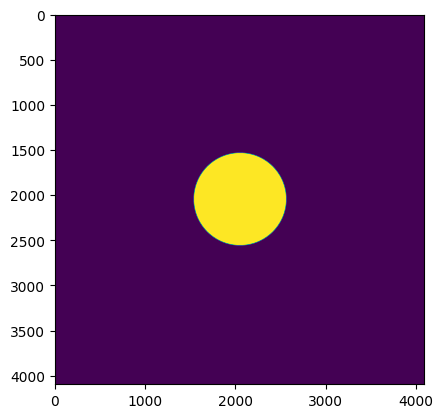

In [58]:
dia = 8
x,y = make_xy_grid(4096,diameter=dia)
mask = np.zeros_like(x)
mask[np.sqrt(x**2 + y**2) < 1] = 1
plt.imshow(mask)

In [83]:
wlen = 1e-6 #um
charge = 6
seam = int(mask.shape[0])/5
input_field = Wavefront.from_amp_and_phase(mask,np.zeros_like(mask),wlen,dia/mask.shape[0])
efl = 20 # efl in mm

natty_res,partitions,n_res_parts = vp.compute_partitions_fixed_samplings(mask.shape[0],
                                                 dia/mask.shape[0],
                                                 efl,
                                                 wlen)

fft_mask = vp.make_fft_mask(charge,
                            x.shape[0], # don't super know what this is
                            natty_res,
                            seam)

mft_masks = [vp.make_zoomed_mask(charge,*e) for e in n_res_parts]

In [82]:
help(vp.make_zoomed_mask)

Help on function make_zoomed_mask in module dygdug.vortexprop:

make_zoomed_mask(charge, n, dx, seam_outer, seam_inner=None)
    Make the masked vortex mask for zoomed propagations.
    
    Parameters
    ----------
    charge : int
        vortex charge (even numbers are better than odd)
    n : int
        number of samples per side of the nxn array
    dx : float
        inter-sample spacing for the FFT propagation (FL/D)
    seam_outer : float
        the coordinate at which the prior propagation hands off to this one
    seam_inner : float, optional
        the coordinate at which this propagation hands off to the next
        (None in the case where this is the final propagation)
    
    Returns
    -------
    numpy.ndarray
        complex mask containing a vortex and high-pass window



In [84]:
fft_field,mft_field = vp.vortex_prop(input_field,efl,fft_mask,n_res_parts,mft_masks)

MemoryError: Unable to allocate 256. MiB for an array with shape (4098, 4096) and data type complex128

In [ ]:
coro_lyot = fft_field.data + mft_field

In [77]:
from prysm.propagation import focus

# build a lyot stop
ls = np.zeros_like(mask)
ls[np.sqrt(x**2 + y**2) < 0.8] = 1 

psf_ref = focus(mask*ls,Q=1)
psf_coro = focus(coro_lyot*ls,Q=1)

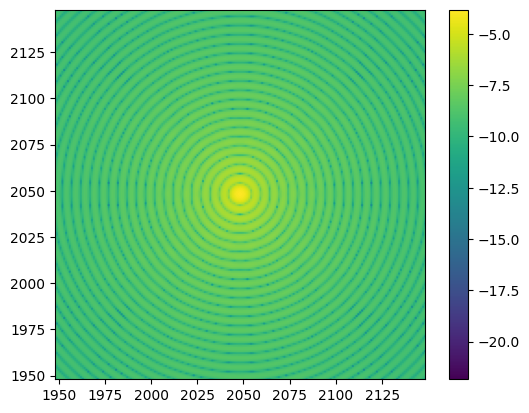

In [78]:
ref_intensity = np.max(np.abs(psf_ref)**2)
coro_focal = np.abs(psf_coro)**2 / ref_intensity
cut = 100
center = coro_focal.shape[0]/2
plt.figure()
plt.imshow(np.log10(coro_focal))
plt.colorbar()
plt.xlim(center-cut,center+cut)
plt.ylim(center-cut,center+cut)
plt.show()

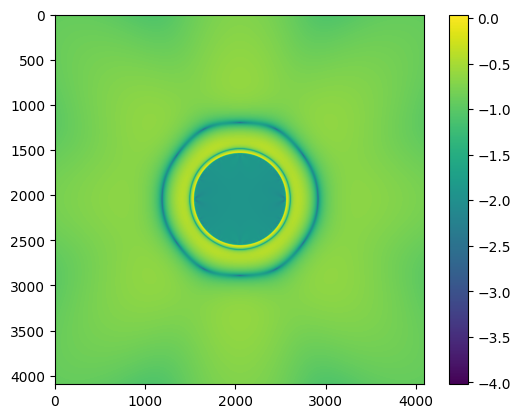

In [79]:
plt.imshow(np.log10(np.abs(coro_lyot)))
plt.colorbar()